# Preterm brain development is heterogeneous
For each modality (i.e., CT, SA, and measures of cerebral tissue volume) and each dataset, we will now show that average dysmaturation outcomes, derived from classic case-control studies, are not representative for individual brain outcomes. Results demonstrate that brain development after preterm birth is highly heterogeneous. 
For this, we will:
1. Calculate the average dysmaturation outcome by comparing preterm subjects to full-term controls using a linear model (brain_measure ~ diagnosis + age + sex)
2. Calculate the individual brain abnormality pattern (IBAP) for each subject based on the BrainChart framework
3. Calculate the percentage of subjects with extranormal deviations
4. Compare spatial similarity of IBAPs among preterm individuals using cross-correlation of binarized IBAPs


In step 2, we will refit the pretrained BrainChart models to the selected dataset. Since this requires some computational power, several cores can be used in parallel to speed up the process (`cpu_num`). The pretrained models and some functions from the original BrainChart project released [here](https://github.com/brainchart/Lifespan) are used.

If you want to run this script with the original data, data access needs to be requested from the respective data owners. Then, `dataset` can be set to `dHCP`, `ABCD-10`, `ABCD-12`, `BLS-26`, or `BLS-38` for the respective datasets used in the current study. 


🌈 To run this script without the access to the original data, set `dataset` to `synthetic_BLS-26`.

In [670]:
# manually set path to R if there are problems with the automatic detection
# import os
# os.environ['R_HOME'] = '/Library/Frameworks/R.framework/R'  # adapt to your R installation

In [671]:
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for braincharts
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [672]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import multipletests

import gc  # for clearing unnecessary variables

sns.set(style='white')

# import custom functions
import sys
sys.path.append('code')
from utils import get_roi_names
from plotting import get_significant_cortical_vals_for_plotting, plot_brain_map, plot_group_difference_global, plot_individual_brain_maps
from spatial_heterogeneity import *
from stats import median_difference_centiles, plot_permuation_test


# some settings - please adapt to your needs
brain_measure = 'SA'  # CT or SA
dataset = 'BLS-38'  
scale = 10  # scale for brain plots; run with scale = 10 for higher resolution
refit_models = False  # whether to repeat adaptation of the pretrained models to the new data, computationally intense
cpu_num = 6  # number of cores to use for refitting BrainChart models

In [673]:
# directories
data_dir = 'data'
outputs_dir = join('outputs', 'spatial_heterogeneity')
os.makedirs(outputs_dir, exist_ok=True)

braincharts_sw_dir = 'Lifespan'

out_dir_main = join(outputs_dir, dataset)
os.makedirs(out_dir_main, exist_ok=True)

# Load data

In [674]:
# get ROI names
rois = get_roi_names(brain_measure, global_vars=True)
rois.append('meanCT2')
rois_cortical = get_roi_names(brain_measure, global_vars=False)

# load preprocessed data
if dataset.startswith('BLS') or dataset.startswith('ABCD'):
    dataset_name = dataset[:-3]
else:
    dataset_name = dataset
data = pd.read_csv(join(data_dir, dataset_name, 'derivatives', f'{dataset}_{brain_measure}_preprocessed.csv'))

# 1. Average dysmaturation outcome after preterm birth

In [675]:
out_dir = join(out_dir_main, 'average_dysmaturation')
os.makedirs(out_dir, exist_ok=True)

if dataset == 'dHCP':
    # filter for term-equivalent age
    data = data[data['scan'] == 'term_equivalent']
    data_fetal = data[data['scan'] == 'fetal']
    print(f'Using {data.shape[0]} term-equivalent scans from dHCP dataset')

## Brain measure

In [676]:
# calculate group difference using OLS regression
tvals_mr = group_comparison(rois_cortical, data, covariates=['age_days', 'sex'])
tvals_mr.to_csv(join(out_dir, f'{dataset}_{brain_measure}_average_dysmaturation.csv'), index=False)

# show table and round every value to 3 decimal places, replace 0.000 with <0.001
tvals_mr_table = tvals_mr.set_index('ROI').round(3).replace(0.000, '<0.001')
tvals_mr_table.to_csv(join(out_dir, f'{dataset}_{brain_measure}_average_dysmaturation_table.csv'), index=True)
display(tvals_mr_table)

,t_statistic,Cohen_d,p_value,p_fdr
ROI,,,,
SA_bankssts,-4.559,0.808,<0.001,<0.001
SA_caudalanteriorcingulate,-0.903,0.128,0.369,0.464
SA_caudalmiddlefrontal,0.348,-0.049,0.729,0.799
SA_cuneus,-1.107,0.178,0.271,0.384
SA_entorhinal,-0.085,0.034,0.932,0.932
SA_fusiform,-2.660,0.407,0.009,0.044
SA_inferiorparietal,-2.966,0.490,0.004,0.032
SA_inferiortemporal,-1.497,0.224,0.138,0.209
SA_isthmuscingulate,-2.245,0.377,0.027,0.07


In [677]:
# plot the t-statistic only for significant ROIs after FDR-correction
sig_t = get_significant_cortical_vals_for_plotting(data=tvals_mr, rois_cortical=rois_cortical, statistic='t_statistic', bilateral=True)

outname = join(out_dir, f'{dataset}_{brain_measure}_avg_dysmaturation_term-preterm.svg')
plot_brain_map(sig_t, outname, scale=scale, limits=(-5, 5))  # larger scale improves image quality


Plotted brain map and saved it to outputs/spatial_heterogeneity/BLS-38/average_dysmaturation/BLS-38_SA_avg_dysmaturation_term-preterm.svg


## Cerebral tissue volume

In [678]:
# Average dysmaturation global
if brain_measure == 'CT':  # run only once
    rois_global = ['WMV', 'GMV', 'sGMV']
    
    tvals_mr = group_comparison(rois_global, data, covariates=['age_days', 'sex'])
    tvals_mr.to_csv(join(out_dir, f'{dataset}_global_average_dysmaturation.csv'), index=False)

    # show table and round every value to 3 decimal places, replace 0.000 with <0.001
    tvals_mr_table = tvals_mr.set_index('ROI').round(3).replace(0.000, '<0.001')
    tvals_mr_table.to_csv(join(out_dir, f'{dataset}_global_average_dysmaturation_table.csv'), index=True)
    display(tvals_mr_table)
    
    
    # plot measures of cerebral tissue volume
    for ctv_measure in rois_global:
        outname = join(out_dir, f'{dataset}_{ctv_measure}_avg_dysmaturation_term-preterm.svg')
        # in dHCP,x one outlier with sGMV = 0 was removed
        data = data[data['sGMV'] > 0]
        # plot the residuals of the group comparison
        plot_group_difference_global(data=data, x='dx', y=ctv_measure, yaxis_label = f'{ctv_measure} residuals [mm$^3$]', outname=outname)

# 2. Individual brain aberration patterns (IBAP) for each subject

In [679]:
out_dir = join(out_dir_main, f'braincharts_model_adapted_{brain_measure}')
os.makedirs(out_dir, exist_ok=True)

out_dir_analysis = join(out_dir_main, f'IBAP_{brain_measure}')
os.makedirs(out_dir_analysis, exist_ok=True)

In [680]:
# adjust settings for ABCD: longitudinal analysis but split into two timepoints after model adaptation again
if dataset_name == 'ABCD':
    # combine two timepoints for longitudinal estimation of random effect of study
    data = pd.read_csv(join(data_dir, dataset_name, 'derivatives', f'{dataset_name}_{brain_measure}_preprocessed.csv'))
    print('Loaded both timepoints for ABCD. Data shape:', data.shape)
    
    if dataset == 'ABCD-10':
        abcd_session = 1
    elif dataset == 'ABCD-12':
        abcd_session = 2
        out_dir = join(outputs_dir, 'ABCD-10', f'braincharts_model_adapted_{brain_measure}')
        
        
if dataset_name == 'dHCP':
    # reload data for dHCP to calculate centiles for all scans
    data = pd.read_csv(join(data_dir, dataset_name, 'derivatives', f'{dataset_name}_{brain_measure}_preprocessed.csv'))
    scan = 'term_equivalent'  # filter for term-equivalent scans only
    # print('Loaded both timepoints for dHCP. Data shape:', data.shape)
    # if dataset == 'dHCP-fetal':
    #     scan = 'fetal'
    #     out_dir = join(outputs_dir, 'dHCP-termequ', f'braincharts_model_adapted_{brain_measure}')
    # elif dataset == 'dHCP-termequ':
    #     scan = 'term_equivalent'

## Refit the pretrained model and calculate deviation scores
The calculation will be done in R. Since the calculation will take some time, it is recommended to adjust the number of cores in `cpu_num` for higher processing speed. However, stick to the limits of your system!

In [681]:
# rois =['WMV'] 
# refit_models = True

In [682]:
%%R -i data -i rois -i out_dir -i braincharts_sw_dir -i cpu_num -i refit_models

# load required functions
source(file.path(braincharts_sw_dir, '920.calc-novel-wo-subset-function.r'))
source('code/braincharts_helpers.R')

if (refit_models == TRUE) {
    # only if refitting is necessary
    
    for (roi in rois) { 
        # adapt the pretrained model for each ROI for the current dataset and calculate deviation scores for each subject in dataset
        if (roi == 'SA_entorhinal') {
            # skip SA entorhinal as BrainChart estimation failed due to low data consistency
            next
        }
        print(roi)
        result <- fit_braincharts_model(roi, data, braincharts_sw_dir, out_dir, plotting=FALSE, ncores=cpu_num)
    } 

} else {
    # Check if the directory exists
    if (!file.exists(out_dir)) {
        warning('Models not yet adapted, please set refit_models to TRUE.')
    } else {
        message('Models already adapted, skipping refitting.')
    }
}

Models already adapted, skipping refitting.


## Plot BrainChart trajectories
As an example region, we will plot the growth trajectory of the insula based on adapted braincharts models. Code from the BrainChart project can be obtained from here: https://github.com/brainchart/Lifespan

In [683]:
roi = f'{brain_measure}_insula'
best_analysis_dir = out_dir

# save current dir for later use
cwd = os.getcwd()

In [684]:
%%R -i braincharts_sw_dir -i out_dir -i cwd -i roi -i best_analysis_dir -i refit_models

if (refit_models == TRUE) {
    library(ggplot2)
    setwd(braincharts_sw_dir)
    source('100.common-variables.r')
    source('101.common-functions.r')
    source('300.variables.r')
    source('301.functions.r')
    setwd(cwd)
    source('code/braincharts_helpers.R')

    plot_pop_curves(roi, braincharts_sw_dir, out_dir, best_analysis_dir)
} 

Plot the corresponding DK region

In [685]:
# mark the relevant rois as 1, the rest is 0
marked_roi = pd.DataFrame(rois_cortical)
marked_roi['filter'] = (marked_roi[0] == roi).astype(int)
roi1 = marked_roi['filter'].to_numpy().squeeze()

# duplicate for visualization
roi1 = np.tile(roi1,(1,2)).squeeze()

# plot
outname = os.path.join(out_dir, f'{roi}_DK_region.svg')
plot_brain_map(roi1, outname, cmap='Greys', limits=(0,1), scale=scale, fill=0)

Plotted brain map and saved it to outputs/spatial_heterogeneity/BLS-38/braincharts_model_adapted_SA/SA_insula_DK_region.svg


## Summarize results
Deviation scores per subject and number of infra- and supranormal regions per subject

In [686]:
# clean up not needed variables to make program run faster
gc.collect()

# summarize deviation scores per subject
if brain_measure == 'CT':
    cent_df = get_centile_scores_per_subject(out_dir, rois, base_file=f'result_deviation_{brain_measure}_middletemporal.csv')
else:
    cent_df = get_centile_scores_per_subject(out_dir, rois_cortical, base_file=f'result_deviation_{brain_measure}_middletemporal.csv')
cent_df = cent_df.merge(data.drop(columns=rois_cortical), on=['participant', 'session'])

# calculate the amount of cortical infra- and supranormal deviation per subject
cent_scores = cent_df.copy()
cent_scores.set_index(['participant', 'session'], inplace=True)
cent_scores = cent_scores.filter(regex=f'centile_{brain_measure}')  # filter only for brain_measure

cent_scores = get_amount_infra_supra(cent_scores)

# merge with cent_df
cent_df = pd.merge(cent_df, cent_scores[['participant','session','amount_infranormal', 'amount_supranormal']], on=['participant', 'session'])

File not found for ROI SA_entorhinal: outputs/spatial_heterogeneity/BLS-38/braincharts_model_adapted_SA/result_deviation_SA_entorhinal.csv - skipping.


In [687]:
# save
print('Data shape:', cent_df.shape)
cent_df.to_csv(join(out_dir_analysis, f'{dataset}_{brain_measure}_centiles_per_subject.csv'), index=False)

Data shape: (105, 53)


## Plot some example subject's deviation scores for each ROI

In [688]:
# plot example subjects for BLS-26
if dataset == 'BLS-26':
    cent_df_pt = cent_df[cent_df['dx']=='preterm']
    cent_df_ft = cent_df[cent_df['dx']=='CN']
    cent_df_pt_ctx = cent_df_pt.filter(regex=f'centile_{brain_measure}|participant')

    subjects = ['BEST-MUC-103', 'BEST-MUC-108', 'BEST-MUC-148',
                'BEST-BN-069', 'BEST-MUC-041', 'BEST-MUC-069']

    for subject in subjects:
        plot_individual_brain_maps(cent_df_pt_ctx, subject, outdir=out_dir_analysis, scale=scale, cmap='RdBu_r', 
                                    limits=(0, 1), infra_supra=True, brain_measure=brain_measure)

# 3. Percentage of subjects with extranormal deviations
Calculate the percentage of subjects with infra- or supranormal deviations for each modality and dataset. For ABCD, BrainChart random study effect were calculated based on longitudinal data. The following results, however, are presented separately for each timepoint. Therefore, the dataset is split again here.

In [689]:
# separate groups
if dataset_name == 'ABCD' :
    # split the dataset into the 2 timepoints again here to report results separately
    cent_df = cent_df[cent_df['session'] == abcd_session].copy()
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']
elif dataset_name == 'dHCP':
    cent_df = cent_df[cent_df['scan'] == scan].copy()
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']
    print(f'{scan} scans: {ft_scores_df.shape[0]} full-term and {pt_scores_df.shape[0]} preterm infants for dHCP')
else: 
    ft_scores_df = cent_df[cent_df['dx']=='CN']
    pt_scores_df = cent_df[cent_df['dx']=='preterm']

In [690]:
# subjects with at least one extranormal deviation
percent_ft_extranormal = percent_extranormal(ft_scores_df)
print(f'Full-term subjects with at least one extranormality: {percent_ft_extranormal:.0f}%')

percent_pt_extranormal = percent_extranormal(pt_scores_df)
print(f'Preterm subjects with at least one extranormality: {percent_pt_extranormal:.0f}%')

Full-term subjects with at least one extranormality: 77%
Preterm subjects with at least one extranormality: 88%


Showing extranormal deviations for dataset: BLS-38


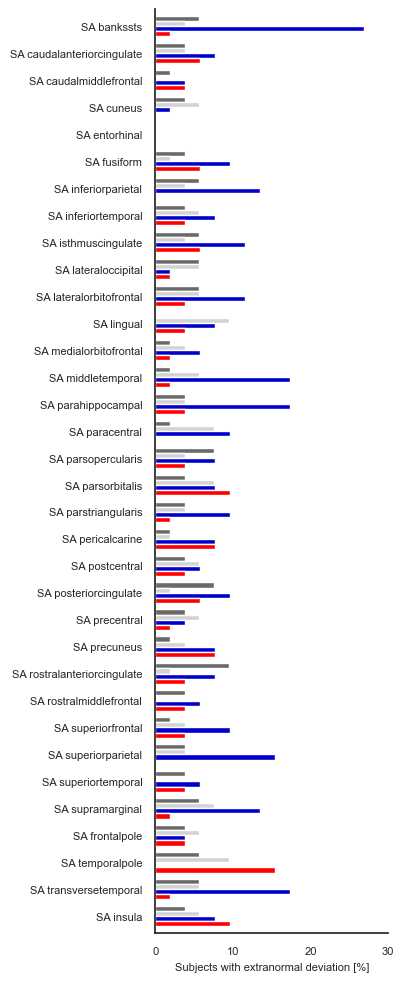

In [691]:
# adjust yticklabels
if brain_measure == 'CT':
    brain_measure_name = 'CTh'
elif brain_measure == 'SA':
    brain_measure_name = 'SA'

# calculate the percentage of subjects with extranormal deviation per ROI
print('Showing extranormal deviations for dataset:', dataset)
rois_cortical_cent = ['centile_' + roi for roi in rois_cortical]
infra_supra_all = calc_infra_supra_percentage(rois_cortical_cent, ft_scores_df, pt_scores_df)



# plot Fig 1d
fsize=8
plt.close('all')

ax = infra_supra_all.plot(x='rois', y=['infranormal_ft', 'supranormal_ft', 'infranormal_pt', 'supranormal_pt'], 
                            kind="barh", rot=0, figsize=(3,12),fontsize=fsize,
                            color=['dimgray','lightgray', 'mediumblue', 'red'],
                            legend=False, width=0.75)
# ax.legend(['Infranormal FT', 'Supranormal FT', 'Infranormal PT', 'Supranormal PT'], fontsize=fsize+1)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Subjects with extranormal deviation [%]', fontsize=fsize)
ax.set_ylabel('')
rois_cortical_names = [brain_measure_name + ' ' + roi.split('_')[1] for roi in rois_cortical]
ax.set_yticklabels(rois_cortical_names)

# set the x-axis limit
xlim = np.round(infra_supra_all[['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt']].max().max()*1.1)
plt.xlim(0, xlim)

sns.despine()

plt.savefig(join(out_dir_analysis, f'{dataset}_{brain_measure}_individual_percentage_outside_norm.svg'), 
            bbox_inches="tight", dpi=300, format='svg')
plt.show()


In [692]:
# # plot regional overlap on brain surface
# outname = join(out_dir_analysis, f'{dataset}_{brain_measure}_regional_overlap_infranormal_pt.svg')
# tmp = infra_supra_all['infranormal_pt'].to_numpy() 
# tmp = np.tile(tmp,(1,2)).squeeze()
# plot_brain_map(tmp, outname, cmap='Blues', limits=(0,30), scale=1, fill=0)


# # plot regional overlap on brain surface
# outname = join(out_dir_analysis, f'{dataset}_{brain_measure}_regional_overlap_infranormal_ft.svg')
# tmp = infra_supra_all['infranormal_ft'].to_numpy() 
# tmp = np.tile(tmp,(1,2)).squeeze()
# plot_brain_map(tmp, outname, cmap='Blues', limits=(0,30), scale=1, fill=0)

In [693]:
# global measures
if brain_measure == 'CT':
    rois_global_cent = ['centile_' + ctv for ctv in rois_global]
    infra_supra_global = calc_infra_supra_percentage(rois_global_cent, ft_scores_df, pt_scores_df)
    
    fsize=8
    plt.close('all')

    ax = infra_supra_global.plot(x='rois', y=['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt'], 
                                kind="barh", rot=0,figsize=(3,12/34*4),fontsize=fsize,
                                color=['dimgray','lightgray', 'mediumblue', 'red'],
                                legend=False)

    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Subjects with extranormal deviation [%]',fontsize=fsize)
    ax.set_ylabel('')
    rois_cortical_names = [roi.split('_')[1] for roi in rois_global_cent]
    ax.set_yticklabels(rois_cortical_names)

    # set the x-axis limit
    xlim = np.round(infra_supra_global[['infranormal_ft','supranormal_ft','infranormal_pt','supranormal_pt']].max().max()*1.1)
    plt.xlim(0, xlim)

    sns.despine()

    plt.savefig(join(out_dir_analysis, f'{dataset}_individual_percentage_outside_norm_global.svg'), 
                bbox_inches="tight", dpi=300, format='svg')
    plt.show()

## Control analysis: median difference of IBAPs between preterm and full-term subjects

In [694]:
# out_dir_supp = join(out_dir_analysis, 'supplement')
# os.makedirs(out_dir_supp, exist_ok=True)

In [695]:
# # compute median differences between full-term and preterm groups for each ROI and conduct permutation tests
# p_perms = dict()

# for roi in rois_cortical:
#     ft_group_data = ft_scores_df[f'centile_{roi}']
#     pt_group_data = pt_scores_df[f'centile_{roi}']
    
#     # conduct permutation test
#     p_value, perm_diffs, median_diff = median_difference_centiles(ft_group_data, pt_group_data, n_permutations=1000, random_state=42)
#     p_perms[roi] =  median_diff, p_value
#     #plot_permuation_test(median_diff, perm_diffs, roi)

# p_perms_df = pd.DataFrame.from_dict(p_perms, orient='index', columns=['median_diff', 'p_value'])
# p_perms_df.index.name = 'ROI'
# p_perms_df.reset_index(inplace=True)
# p_perms_df['p_fdr'] = multipletests(p_perms_df['p_value'], method='fdr_bh')[1]
# p_perms_df

In [696]:
# # plot significant results
# sig_median = get_significant_cortical_vals_for_plotting(data=p_perms_df, rois_cortical=rois_cortical, 
#                                                         statistic='median_diff', bilateral=True)

# outname = join(out_dir_supp, f'{dataset}_{brain_measure}_median_diff_centiles_term-preterm.png')
# plot_brain_map(sig_median, outname, scale=10, limits=(-0.5, 0.5))  # larger scale improves image quality

# 4. Compare spatial similarity of IBAPs among preterm individuals 


In [697]:
out_dir = join(out_dir_main, f'IBAP_similarity_{brain_measure}')
os.makedirs(out_dir, exist_ok=True)

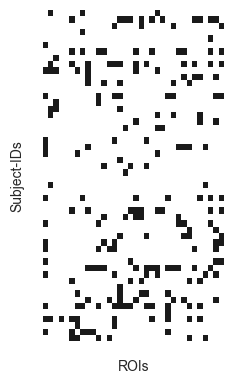

In [698]:
# binarize extranormal deviations of preterm subjects (Fig. 1e)
plt.close('all')
cent_df_pt = cent_df[cent_df['dx']=='preterm']
dev_scores_stripped_pt = cent_df_pt.filter(regex=f'centile_{brain_measure}')
dev_scores_stripped_pt_bin = binarize_extranormal(dev_scores_stripped_pt)

# plot binarized values per subject
outname = join(out_dir, f'bin_{brain_measure}_deviations_pt.svg')
plot_binarized_extranormal(dev_scores_stripped_pt_bin, title='', outname=outname)

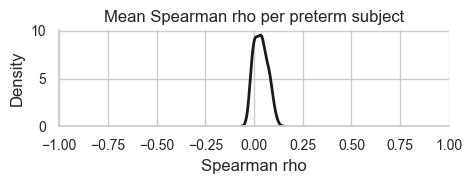

In [699]:
# subject x subject correlation matrix (Fig. 1f+g)
corr_matrix_pt_subjects_01 = dev_scores_stripped_pt_bin.T.corr(method='spearman')

if dataset == 'BLS-26' and brain_measure == 'CT':
    # plot extended version for Fig.2f+g
    outname = join(out_dir, f'corrmatrix_bin_{brain_measure}_deviations.svg')
    plot_correlation_matrix_kde(corr_matrix_pt_subjects_01, outname)
    
else:
    # plot simplified version for all others
    outname = join(out_dir, f'corrmatrix_bin_{brain_measure}_deviations.svg')
    title = 'Mean Spearman rho per preterm subject'
    plot_mean_rho(corr_matrix_pt_subjects_01, title, outname)

## Supplementary analysis: IBAP similarity without binarization

In [700]:
out_dir = join(out_dir_main, f'IBAP_similarity_{brain_measure}', 'supplement')
os.makedirs(out_dir, exist_ok=True)

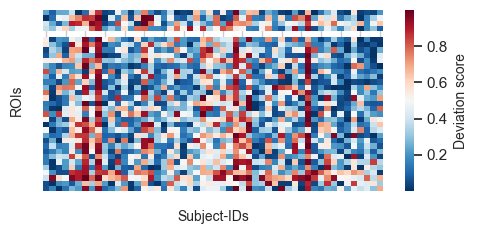

In [701]:
plt.close('all')
cent_df_pt = cent_df[cent_df['dx']=='preterm']
dev_scores_stripped_pt = cent_df_pt.filter(regex=f'centile_{brain_measure}')

# plot binarized values per subject
outname = join(out_dir, f'{brain_measure}_deviations_pt.svg')
plot_binarized_extranormal(dev_scores_stripped_pt, title='', outname=outname, bin=False)

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/spatial_heterogeneity.py:304: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(row_means, ax=ax_kde, vertical=True, fill=False, color='k')


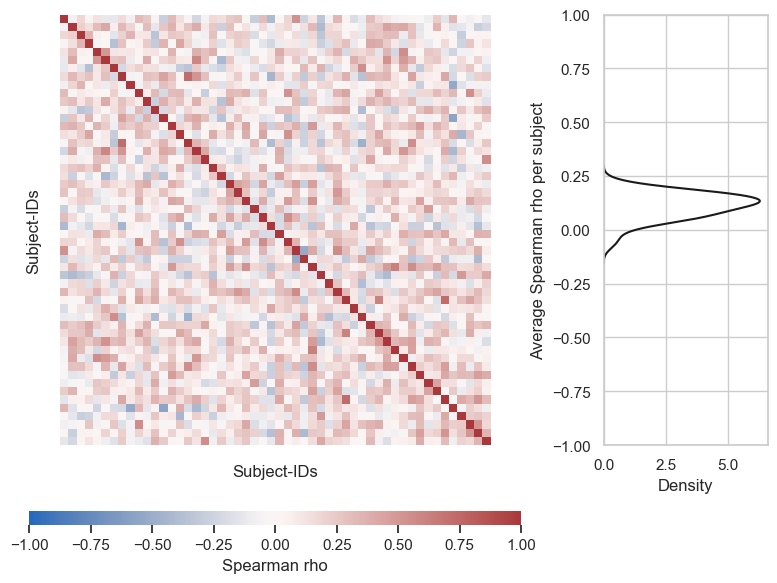

In [702]:
# subject x subject correlation matrix (Fig. 1f+g)
corr_matrix_pt_subjects = dev_scores_stripped_pt.T.corr(method='spearman')


outname = join(out_dir, f'corrmatrix_{brain_measure}_deviations.svg')
plot_correlation_matrix_kde(corr_matrix_pt_subjects, outname)



## Supplementary analysis: average correlation of IBAPs among preterm individuals
Binarized IBAPs are used to investigate whether there are patterns of extranormal deviations in the preterm group.


/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/spatial_heterogeneity.py:304: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(row_means, ax=ax_kde, vertical=True, fill=False, color='k')


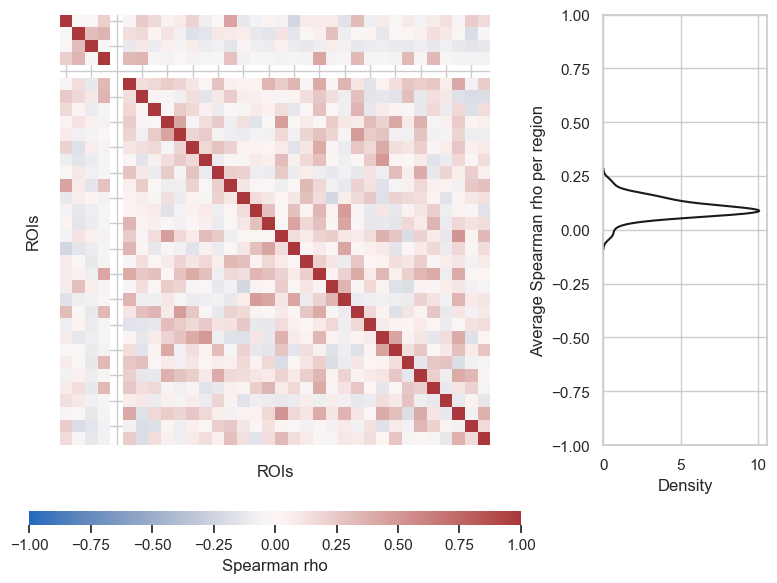

In [703]:
# region x region correlation matrix
corr_matrix_pt_subjects_rois = dev_scores_stripped_pt_bin.corr(method='spearman')

outname = join(out_dir, f'corrmatrix_{brain_measure}_deviations_regional_similarity.svg')
plot_correlation_matrix_kde(corr_matrix_pt_subjects_rois, outname, across='regions')